# CHAOS Stellar Mass Density Profiles

```bash
# Get JPEG and FITS cutouts of the sample.

# NGC0628
# http://legacysurvey.org/viewer-dev?ra=24.1741665&dec=15.7834583&zoom=12&layer=decals-dr7&lslga
wget -c -O NGC0628-SDSS.jpg "http://legacysurvey.org/viewer/jpeg-cutout?ra=24.1741665&dec=15.7834583&pixscale=0.396&size=2000&layer=sdss"
wget -c -O NGC0628-SDSS.fits wget "http://legacysurvey.org/viewer/fits-cutout?ra=24.1741665&dec=15.7834583&pixscale=0.396&size=2000&layer=sdss"

# NGC5194
# http://legacysurvey.org/viewer-dev?ra=202.469547&dec=47.195151&zoom=11&layer=mzls+bass-dr6&lslga
wget -c -O NGC5194-SDSS.jpg "http://legacysurvey.org/viewer/jpeg-cutout?ra=202.469547&dec=47.195151&pixscale=0.396&size=2000&layer=sdss"
wget -c -O NGC5194-SDSS.fits "http://legacysurvey.org/viewer/fits-cutout?ra=202.469547&dec=47.195151&pixscale=0.396&size=2000&layer=sdss"

# NGC5457
# http://legacysurvey.org/viewer-dev?ra=210.802368&dec=54.349023&zoom=10&layer=mzls+bass-dr6&lslga
wget -c -O NGC5457-SDSS.jpg "http://legacysurvey.org/viewer/jpeg-cutout?ra=210.802368&dec=54.349023&pixscale=0.396&size=3000&layer=sdss"
wget -c -O NGC5457-SDSS.fits "http://legacysurvey.org/viewer/fits-cutout?ra=210.802368&dec=54.349023&pixscale=0.396&size=3000&layer=sdss"

# NGC3184
# http://legacysurvey.org/viewer-dev?ra=154.570590&dec=41.4243426&zoom=12&layer=mzls+bass-dr6&lslga
wget -c -O NGC3184-SDSS.jpg "http://legacysurvey.org/viewer/jpeg-cutout?ra=154.570590&dec=41.4243426&pixscale=0.396&size=1500&layer=sdss"
wget -c -O NGC3184-SDSS.fits "http://legacysurvey.org/viewer/fits-cutout?ra=154.570590&dec=41.4243426&pixscale=0.396&size=1500&layer=sdss"

montage -bordercolor white -borderwidth 1 -tile 2x2 -geometry +0+0 -resize 1024 \
  NGC0628-SDSS.jpg NGC3184-SDSS.jpg NGC5194-SDSS.jpg NGC5457-SDSS.jpg chaos.png
```

In [1]:
import os
import numpy as np
import numpy.ma as ma
import fitsio
from astropy.table import Column

In [11]:
import LSLGA.io
import LSLGA.misc
from LSLGA.ellipse import ellipsefit_multiband

In [3]:
maxsma = 100
band = ('g', 'r', 'i')
psfsize = np.array(1.3).astype('f4') # [FWHM, arcsec]

In [4]:
sample = LSLGA.io.read_parent(chaos=True)
for filt in band:
    sample['PSFSIZE_{}'.format(filt.upper())] = np.repeat(psfsize, len(sample))
#sample['DISTANCE'] = np.array()
#NGC628: 7.2 Mpc NGC5194: 7.9 Mpc NGC5457: 7.4 MpcNGC3184: 11.6 Mpc
sample

LSLGA_ID,GALAXY,PGC,RA,DEC,TYPE,BAR,RING,MULTIPLE,COMPACTNESS,T,PA,D25,BA,DIAM_REF,Z,SB_D25,MAG,MAG_REF,WISE_RA,WISE_DEC,CNTR,W1MPRO,W1SIGMPRO,W2MPRO,W2SIGMPRO,W3MPRO,W3SIGMPRO,W4MPRO,W4SIGMPRO,RCHI2,CC_FLAGS,EXT_FLG,PH_QUAL,XSCPROX,W1RSEMI,W1BA,W1PA,W1GMAG,W1GERR,W2GMAG,W2GERR,W3GMAG,W3GERR,W4GMAG,W4GERR,IN_ALLWISE,IN_DESI,NEAR_BRIGHTSTAR,DR,PSFSIZE_G,PSFSIZE_R,PSFSIZE_I
int64,bytes29,int64,float64,float64,bytes4,bytes3,bytes3,bytes3,bytes3,float32,float32,float32,float32,bytes3,float32,float32,float32,bytes1,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float32,bytes4,int32,bytes4,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,bool,bool,bytes3,float32,float32,float32
518063,NGC0628,5974,24.174166500000002,15.783458300000001,Sc,nan,nan,nan,nan,5.2,nan,9.88553,0.94406086,iso,0.002196186,23.308481,9.705,B,24.1741387,15.7836868,234115101351047933,10.655,0.023,10.695,0.023,9.342,0.074,8.271,0.374,32.27,0000,5,AAAC,0.87,126.96,0.95,70.0,7.093,0.01,6.986,0.011,3.632,0.01,1.76,0.015,True,True,False,DR7,1.3,1.3,1.3
1073844,NGC5194,47404,202.469547,47.195151,SABb,B,nan,M,nan,4.0,163.0,13.708821,0.85113806,iso,0.0015370633,22.921482,8.608,B,202.4696996,47.1951717,2029146901351042304,8.84,0.024,8.664,0.02,6.19,0.023,3.386,0.036,46.18,hhdd,5,AAAA,0.43,180.0,0.91,45.0,5.43,0.014,5.404,0.006,1.509,0.006,-0.28,0.03,True,True,False,DR6,1.3,1.3,1.3
1237406,NGC5457,50063,210.80236799999997,54.349022999999995,SABc,B,nan,M,nan,5.9,nan,23.988337,0.9616123,iso,0.0007902133,23.88948,8.361,B,210.8021726,54.3487903,2119154501351013505,10.348,0.023,10.213,0.021,6.624,0.018,4.453,0.029,33.86,0000,5,AAAA,0.56,180.0,0.98,28.0,6.751,0.019,6.704,0.019,3.397,0.024,1.778,0.104,True,True,False,DR6,1.3,1.3,1.3
1253132,NGC3184,30087,154.57058999999998,41.4243426,SABc,B,nan,nan,nan,5.9,nan,7.396052,0.97050995,iso,0.0019753666,23.384481,10.411,B,154.5705508,41.424279,1542140801351054772,10.97,0.023,10.88,0.021,7.418,0.021,4.711,0.03,23.9,0000,5,AAAA,0.69,115.66,0.97,60.0,7.652,0.011,7.517,0.011,4.133,0.008,2.339,0.017,True,True,False,DR6,1.3,1.3,1.3


In [5]:
datadir = os.path.join( LSLGA.io.LSLGA_dir(), 'science', 'chaos' )

In [6]:
gal = 'NGC0628'
imgfile = os.path.join(datadir, '{}-SDSS.fits'.format(gal))
img = fitsio.read(imgfile)

In [7]:
data = dict()
data['band'] = band
data['refband'] = 'r'
data['pixscale'] = 0.396
for filt, indx in zip( data['band'], (0, 1, 2) ):
    sbimg = img[indx, :, :] / data['pixscale']**2
    data[filt] = sbimg
    data['{}_masked'.format(filt)] = ma.masked_array(sbimg, np.zeros_like(sbimg))

In [13]:
%time ell = ellipsefit_multiband(gal, datadir, data, sample[0], maxsma=maxsma, noellipsefit=True, verbose=True)

Finding the galaxy in the reference r-band image.
 Pixels used: 366203
 Peak Img[j, k]: 1001 1001
 Mean (j, k): 996.89 995.07
 Theta (deg): 103.1
 Astro PA (deg): 166.9
 Eps: 0.143
 Major axis (pix): 468.2
Ellipse-fitting the reference r-band image.
  Trying sma0 = 1.0 pixels.
Time = 17.898 sec
Ellipse-fitting g-band image.
Time = 14.875 sec
Ellipse-fitting i-band image.
Time = 12.502 sec
Time for all images = 27.378 sec
Writing /Users/ioannis/research/projects/LSLGA/science/chaos/NGC0628-ellipsefit-fixed.p
CPU times: user 1min 8s, sys: 1.49 s, total: 1min 9s
Wall time: 52.4 s


In [14]:
LSLGA.misc.arcsec2kpc(ell['redshift'])

0.045477768090051225

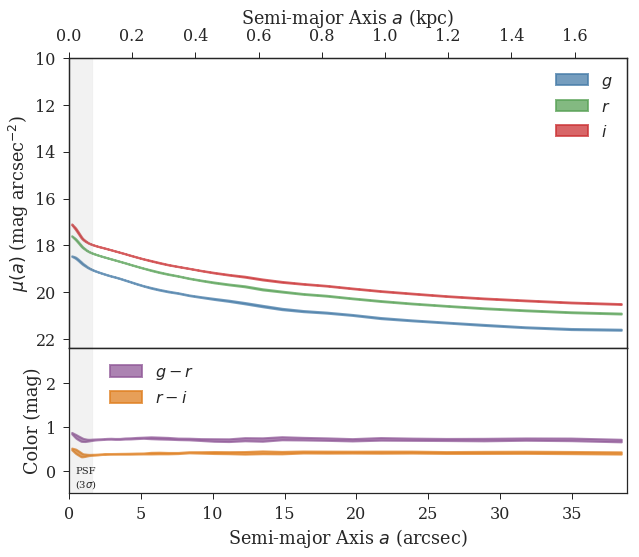

In [15]:
from LSLGA.qa import display_ellipse_sbprofile
display_ellipse_sbprofile(ell)